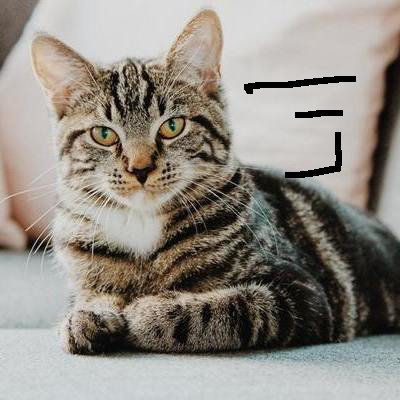

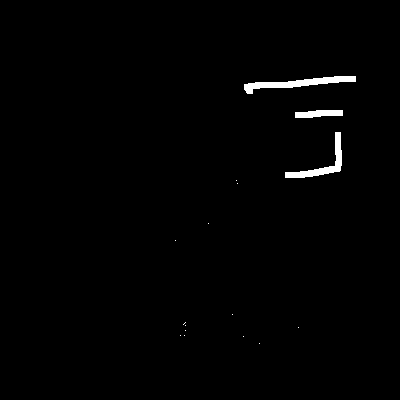

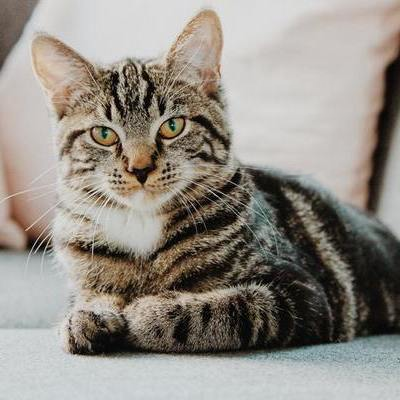

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# reading the damaged image
damaged_img = cv2.imread(filename=r"cat_damaged.png")
cv2_imshow(damaged_img)

# get the shape of the image
height, width = damaged_img.shape[0], damaged_img.shape[1]

# Converting all pixels greater than zero to black while black becomes white
for i in range(height):
    for j in range(width):
        if damaged_img[i, j].sum() > 0:
            damaged_img[i, j] = 0
        else:
            damaged_img[i, j] = [255, 255, 255]

# saving the mask
mask = damaged_img
cv2.imwrite('mask.jpg', mask)
# displaying mask
cv2_imshow(mask)

# Open the image.
img = cv2.imread('cat_damaged.png')

# Load the mask.
mask = cv2.imread('cat_mask.png', 0)

# Inpaint.
dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
cv2_imshow(dst)

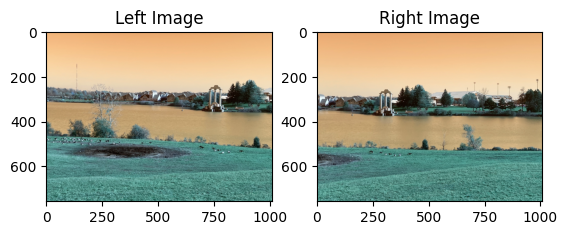

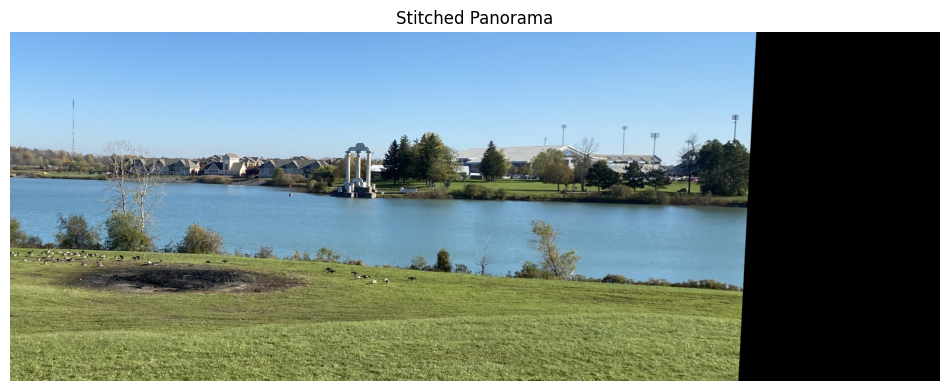

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


img1 = cv2.imread('left.jpg')
img2 = cv2.imread('right.jpg')

# Feature detection
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Feature matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort and extract matched points
matches = sorted(matches, key=lambda x: x.distance)
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Homography
H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)

# Warp
result = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

# Convert BGR to RGB for proper color display
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1); plt.imshow(img1); plt.title("Left Image")
plt.subplot(1,2,2); plt.imshow(img2); plt.title("Right Image")


plt.figure(figsize=(12, 6))
plt.imshow(result_rgb)
plt.title("Stitched Panorama")
plt.axis('off')
plt.show()


In [ ]:
# Assuming kp1, kp2, pts1, pts2 as from above matching step

# Camera intrinsic matrix (assumed or known)
K = np.array([[1000, 0, 320],
              [0, 1000, 240],
              [0, 0, 1]])

# Essential matrix
E, _ = cv2.findEssentialMat(pts1, pts2, K)

# Recover pose
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("Rotation:\n", R)
print("Translation:\n", t)


Rotation:
 [[ 0.98897214  0.03448829 -0.14403007]
 [ 0.00817253  0.95831786  0.28558726]
 [ 0.147876   -0.28361493  0.94746781]]
Translation:
 [[-0.74597192]
 [-0.66574107]
 [-0.01774061]]


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1217 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1124 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1119 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Average PSNR: 10.231112735863707


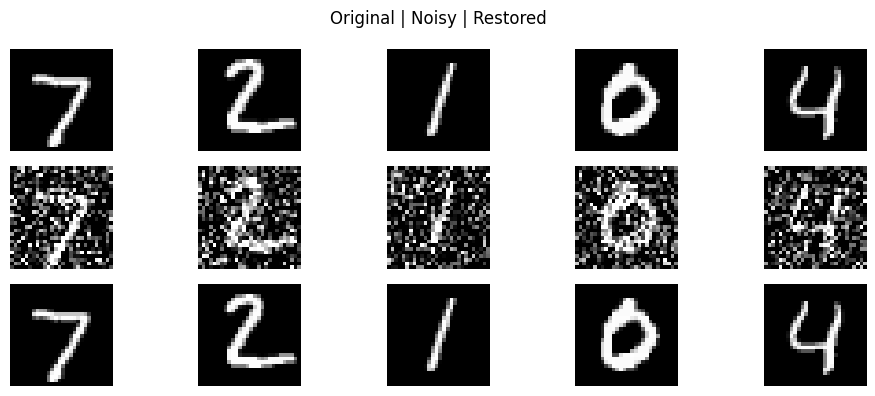

In [ ]:
# ================================
# IMAGE RESTORATION WITH AUTOENCODER (MNIST)
# ================================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Step 1: Load & Preprocess Data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Step 2: Simulate Degradation (Gaussian Noise)
def add_noise(images):
    noise = np.random.normal(loc=0.0, scale=0.5, size=images.shape)
    noisy = np.clip(images + noise, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Step 3: Autoencoder Model
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output_img = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

# Step 4: Train Model
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Step 5: Evaluate & Plot
predicted = autoencoder.predict(x_test_noisy)

# PSNR
print("Average PSNR:", np.mean([psnr(x_test[i], predicted[i]) for i in range(100)]))

# Plot Examples
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, n, i+1+n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, n, i+1+2*n)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Original | Noisy | Restored")
plt.tight_layout()
plt.show()

# ================================
# GAN + MOBILENET + UNET COMING NEXT
# ================================
# Let me know if you want them combined in this same script or separate files.


100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


MNIST (TensorFlow) Epoch [1/50] G_loss: 3.9577, D_loss: 0.1218
MNIST (TensorFlow) Epoch [2/50] G_loss: 4.5269, D_loss: 0.0682
MNIST (TensorFlow) Epoch [3/50] G_loss: 5.3332, D_loss: 0.1902
MNIST (TensorFlow) Epoch [4/50] G_loss: 3.8088, D_loss: 0.6875
MNIST (TensorFlow) Epoch [5/50] G_loss: 3.1576, D_loss: 0.4199
MNIST (TensorFlow) Epoch [6/50] G_loss: 3.1691, D_loss: 0.8733
MNIST (TensorFlow) Epoch [7/50] G_loss: 3.8417, D_loss: 0.3354
MNIST (TensorFlow) Epoch [8/50] G_loss: 3.4135, D_loss: 0.4607
MNIST (TensorFlow) Epoch [9/50] G_loss: 1.7758, D_loss: 1.0166
MNIST (TensorFlow) Epoch [10/50] G_loss: 1.8302, D_loss: 1.7268
MNIST (TensorFlow) Epoch [11/50] G_loss: 1.3271, D_loss: 1.4693
MNIST (TensorFlow) Epoch [12/50] G_loss: 1.1757, D_loss: 1.3217
MNIST (TensorFlow) Epoch [13/50] G_loss: 1.8363, D_loss: 0.7877
MNIST (TensorFlow) Epoch [14/50] G_loss: 2.3211, D_loss: 0.5331
MNIST (TensorFlow) Epoch [15/50] G_loss: 2.6884, D_loss: 0.5277
MNIST (TensorFlow) Epoch [16/50] G_loss: 1.5848, 

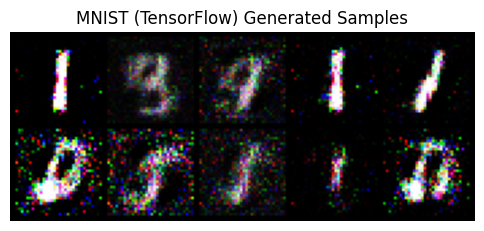

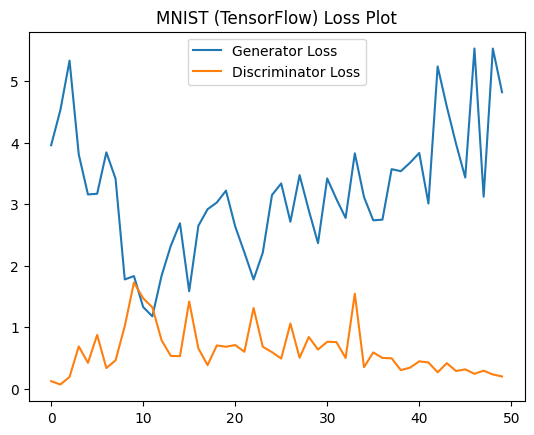

CIFAR-10 Epoch [1/50] G_loss: 1.1801, D_loss: 0.4499
CIFAR-10 Epoch [2/50] G_loss: 4.2682, D_loss: 0.1057
CIFAR-10 Epoch [3/50] G_loss: 3.3316, D_loss: 0.1341
CIFAR-10 Epoch [4/50] G_loss: 3.1801, D_loss: 0.1430
CIFAR-10 Epoch [5/50] G_loss: 2.5316, D_loss: 0.2736
CIFAR-10 Epoch [6/50] G_loss: 5.6231, D_loss: 0.1553
CIFAR-10 Epoch [7/50] G_loss: 3.5854, D_loss: 0.1218
CIFAR-10 Epoch [8/50] G_loss: 4.7412, D_loss: 0.0685
CIFAR-10 Epoch [9/50] G_loss: 4.3110, D_loss: 0.2071
CIFAR-10 Epoch [10/50] G_loss: 4.7700, D_loss: 0.1364
CIFAR-10 Epoch [11/50] G_loss: 4.8034, D_loss: 0.1883
CIFAR-10 Epoch [12/50] G_loss: 4.0170, D_loss: 0.1203
CIFAR-10 Epoch [13/50] G_loss: 4.7496, D_loss: 0.1894
CIFAR-10 Epoch [14/50] G_loss: 4.1041, D_loss: 0.1070
CIFAR-10 Epoch [15/50] G_loss: 3.8789, D_loss: 0.1928
CIFAR-10 Epoch [16/50] G_loss: 4.6861, D_loss: 0.1752
CIFAR-10 Epoch [17/50] G_loss: 4.5317, D_loss: 0.1383
CIFAR-10 Epoch [18/50] G_loss: 4.4470, D_loss: 0.1310
CIFAR-10 Epoch [19/50] G_loss: 5.2009

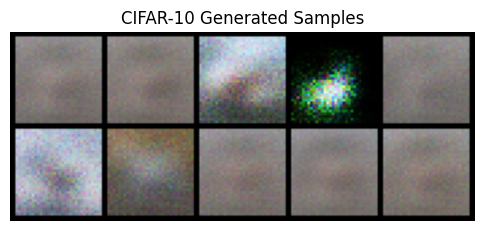

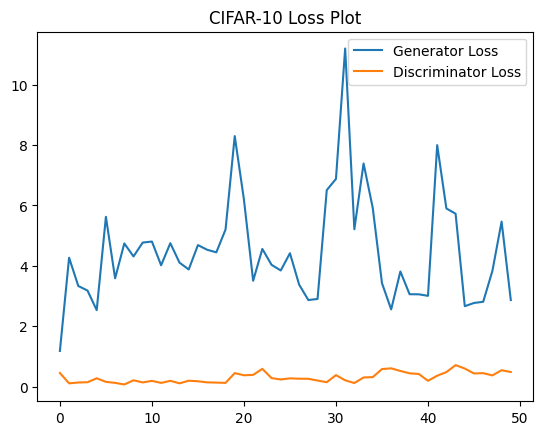

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tensorflow.keras.datasets import mnist as tf_mnist
import numpy as np
import matplotlib.pyplot as plt

# Device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
epochs = 50
batch_size = 128

# CIFAR-10 Transform
transform_cifar = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10
cifar = datasets.CIFAR10(root='./data', train=True, transform=transform_cifar, download=True)
cifar_loader = torch.utils.data.DataLoader(cifar, batch_size=batch_size, shuffle=True)

# Load MNIST using TensorFlow and convert to 3 channels
(train_images, _), (_, _) = tf_mnist.load_data()
train_images = np.expand_dims(train_images, axis=1)  # (N, 1, 28, 28)
train_images = torch.tensor(train_images, dtype=torch.float32) / 127.5 - 1.0
train_images = torch.nn.functional.interpolate(train_images, size=32)  # Resize to 32x32
train_images = train_images.repeat(1, 3, 1, 1)  # Convert to RGB
mnist_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32 * 32 * 3),
            nn.Tanh()
        )
    def forward(self, z):
        return self.gen(z).view(-1, 3, 32, 32)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.dis(x)

# GAN training function
def train_gan(dataloader, label):
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    loss_fn = nn.BCELoss()
    opt_G = optim.Adam(generator.parameters(), lr=2e-4)
    opt_D = optim.Adam(discriminator.parameters(), lr=2e-4)
    g_loss_hist, d_loss_hist = [], []

    for epoch in range(epochs):
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.to(device)
            batch_size = x.size(0)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake = generator(z)

            # Discriminator
            d_real = discriminator(x)
            d_fake = discriminator(fake.detach())
            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Generator
            d_fake = discriminator(fake)
            g_loss = loss_fn(d_fake, real_labels)
            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        g_loss_hist.append(g_loss.item())
        d_loss_hist.append(d_loss.item())
        print(f'{label} Epoch [{epoch+1}/{epochs}] G_loss: {g_loss.item():.4f}, D_loss: {d_loss.item():.4f}')

    # Final generation
    z = torch.randn(10, latent_dim).to(device)
    fake_images = generator(z).detach().cpu()
    grid = make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.title(f'{label} Generated Samples')
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

    # Plot loss
    plt.plot(g_loss_hist, label='Generator Loss')
    plt.plot(d_loss_hist, label='Discriminator Loss')
    plt.title(f'{label} Loss Plot')
    plt.legend()
    plt.show()

# Train on MNIST (from TensorFlow)
train_gan(mnist_loader, "MNIST (TensorFlow)")

# Train on CIFAR-10
train_gan(cifar_loader, "CIFAR-10")


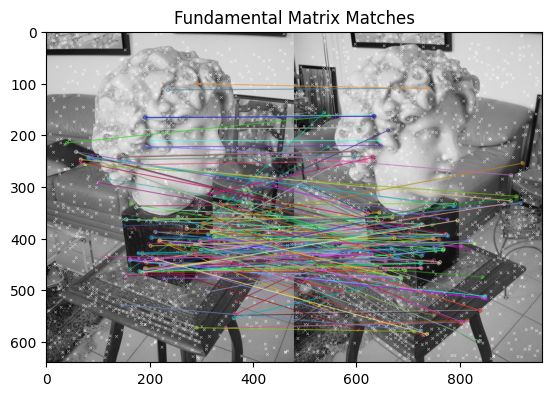

Fundamental Matrix:
 [[-9.76247407e-06 -3.59391041e-05  3.73613825e-03]
 [ 5.21811415e-05  1.87876572e-06  1.33845825e-02]
 [-7.54207995e-03 -1.70071378e-02  1.00000000e+00]]
Essential Matrix:
 [[ 0.16060035 -0.07410665 -0.4447744 ]
 [ 0.09536127 -0.17171247 -0.48885902]
 [ 0.4727646   0.51931993 -0.01139424]]
Rotation Matrix:
 [[ 0.94202749  0.05784858  0.33051134]
 [ 0.0547063   0.94536552 -0.32138956]
 [-0.33104596  0.32083886  0.88739563]]
Translation Vector:
 [[-0.73605906]
 [ 0.66699013]
 [ 0.11550424]]


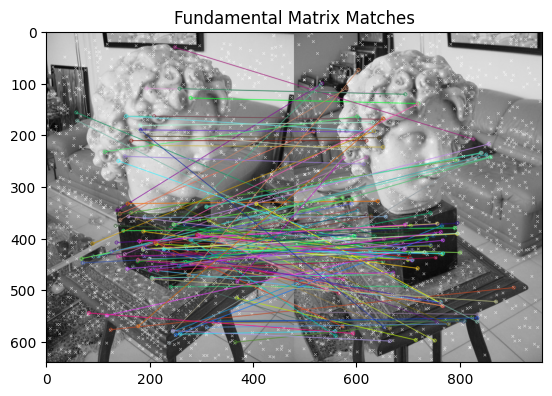

Fundamental Matrix:
 [[-1.16118786e-05 -8.94163386e-05  4.27672518e-02]
 [ 8.52067599e-05  9.34204975e-06 -2.51671874e-02]
 [-3.45132249e-02  1.68169816e-02  1.00000000e+00]]
Essential Matrix:
 [[-0.22665366 -0.66625824  0.06850664]
 [ 0.66456797 -0.21957679  0.06951493]
 [-0.07071418  0.01713741 -0.00662205]]
Rotation Matrix:
 [[ 0.94563532 -0.31239217  0.0904708 ]
 [ 0.31318083  0.94967635  0.00571012]
 [-0.08770178  0.02293403  0.99588274]]
Translation Vector:
 [[ 0.00835679]
 [-0.10298659]
 [-0.99464764]]


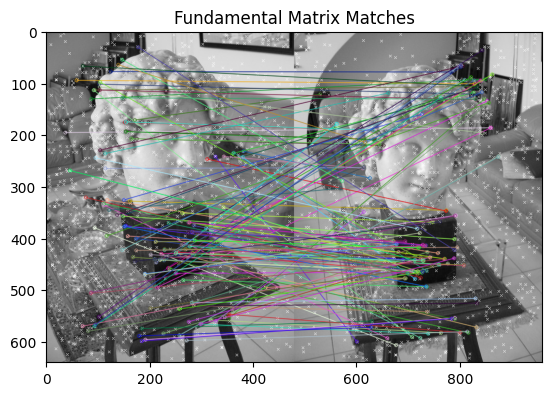

Fundamental Matrix:
 [[ 1.80203483e-05 -3.57121931e-06 -3.18767688e-03]
 [ 9.26827462e-06 -4.19238812e-06 -4.31467186e-04]
 [-8.77297319e-03  2.81475505e-03  1.00000000e+00]]
Essential Matrix:
 [[ 0.02780218  0.15411729  0.0653579 ]
 [-0.02094572  0.02675083 -0.70357835]
 [ 0.11257009  0.67991193  0.00861176]]
Rotation Matrix:
 [[ 0.94990266 -0.25057824  0.1868033 ]
 [ 0.24955374  0.9679154   0.02937194]
 [-0.18816976  0.01871698  0.98195815]]
Translation Vector:
 [[-0.97077623]
 [-0.08744337]
 [ 0.22348863]]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images (replace with actual uploaded file names)
img1 = cv2.imread('head1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('head2.jpg', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('head3.jpg', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('head4.jpg', cv2.IMREAD_GRAYSCALE)

# Function to process each pair of images
def process_images(img1, img2, K):
    # Detect ORB features
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Find the Fundamental matrix
    F, mask_F = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

    # If you want to draw the inliers based on the fundamental matrix
    inliers1 = pts1[mask_F.ravel() == 1]
    inliers2 = pts2[mask_F.ravel() == 1]

    # Draw the matches (optional)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, matchesMask=mask_F.ravel().tolist(), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the image matches using matplotlib
    plt.imshow(img_matches)
    plt.title('Fundamental Matrix Matches')
    plt.show()

    # Find the Essential matrix using the camera intrinsic matrix (assuming it's known)
    E, mask_E = cv2.findEssentialMat(pts1, pts2, K)

    # Recover pose from the essential matrix
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

    # Display the results
    print("Fundamental Matrix:\n", F)
    print("Essential Matrix:\n", E)
    print("Rotation Matrix:\n", R)
    print("Translation Vector:\n", t)

# Example intrinsic matrix (replace with actual matrix if known)
K = np.array([[1000, 0, img1.shape[1] / 2],
              [0, 1000, img1.shape[0] / 2],
              [0, 0, 1]])

# Process image pairs (img1-img2, img2-img3, img3-img4)
process_images(img1, img2, K)
process_images(img2, img3, K)
process_images(img3, img4, K)
